In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

# Data Import

In [5]:
data_1lead = import_afc_data()

data_1lead = [x for x in data_1lead if x[1] != '~']

labelmap = {x:i for i,x in enumerate(list(set([x[1] for x in data_1lead])))}

dataset_1lead = WindowDataset(data_1lead, labelmap, device=device)

100%|██████████| 8528/8528 [00:01<00:00, 7426.73it/s]
8249it [00:02, 2898.60it/s]


In [6]:

from scipy.signal import sawtooth, square

class PartialDataset(WindowDataset):
    def __init__(self, data, labelmap, augment_map, threshold_length=1000, device='cpu', eval=False, trim=None, trim_samples=None):
        super().__init__(data, labelmap, threshold_length, device, eval, trim, trim_samples)
        
        for i in range(len(self.data)):
            waveform, label = self.data[i]

            sintrue = random.uniform(0, 1) > 0.5
            if sintrue:
                label = torch.tensor(0, device=waveform.device)
            else:
                label = torch.tensor(1, device=waveform.device)

            for j in range(12):
                if augment_map[j]:
                    amplitude = random.uniform(0.7, 1.5)
                    frequency = random.uniform(2, 20)

                    t = np.linspace(0, 1, waveform.shape[0], endpoint=False)
                    t += random.uniform(0,1) # start at a random point within the wave

                    if sintrue:
                        augment_waveform = amplitude * np.sin(2 * np.pi * frequency * t)
                    else:
                        augment_waveform = amplitude * square(2 * np.pi * frequency * t)

                    waveform[:,j] = torch.from_numpy(augment_waveform)

            self.data[i] = (waveform, label)

In [7]:
data_12lead = import_balanced_12lead_data()

dataset_12lead = PartialDataset(data_12lead, labelmap, [True] * 12, device=device, trim_samples=1000)

3318it [00:03, 999.53it/s] 


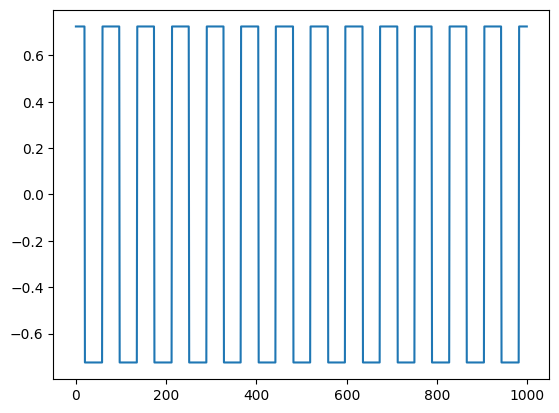

In [8]:
sample = dataset_12lead.__getitem__(11)
plt.plot(sample[0][:,4].cpu().numpy())

Fold 1
Epoch:10/100 AVG Training Loss:0.00302 AVG Test Loss:0.00174 AVG Training F1 99.97 % AVG Test F1 100.00 %
Epoch:20/100 AVG Training Loss:0.00529 AVG Test Loss:0.00159 AVG Training F1 99.77 % AVG Test F1 100.00 %
Epoch:30/100 AVG Training Loss:0.00153 AVG Test Loss:0.00070 AVG Training F1 100.00 % AVG Test F1 100.00 %
Epoch:40/100 AVG Training Loss:0.00152 AVG Test Loss:0.00103 AVG Training F1 99.97 % AVG Test F1 100.00 %
Epoch:50/100 AVG Training Loss:0.00108 AVG Test Loss:0.00057 AVG Training F1 99.97 % AVG Test F1 100.00 %
Epoch:60/100 AVG Training Loss:0.00089 AVG Test Loss:0.00050 AVG Training F1 100.00 % AVG Test F1 100.00 %
Epoch:70/100 AVG Training Loss:0.00100 AVG Test Loss:0.00052 AVG Training F1 100.00 % AVG Test F1 100.00 %
Epoch:80/100 AVG Training Loss:0.00086 AVG Test Loss:0.00048 AVG Training F1 100.00 % AVG Test F1 100.00 %
Epoch:90/100 AVG Training Loss:0.00081 AVG Test Loss:0.00061 AVG Training F1 100.00 % AVG Test F1 100.00 %
Epoch:100/100 AVG Training Loss:0.

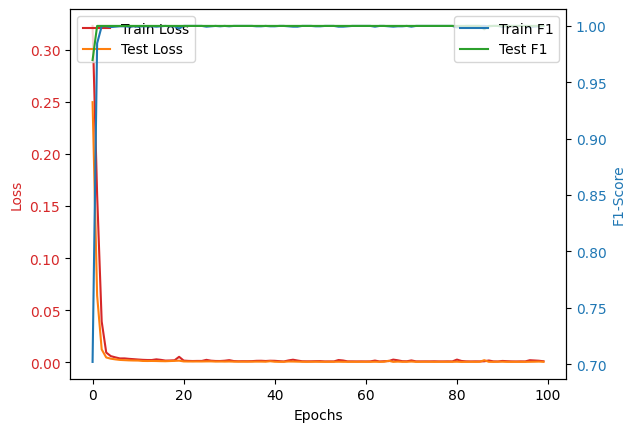

Overall results of 10 fold cross-validation with leave-1-out
Train: Average loss 0.0010292129591107368, average F1 score 100.0
Test: Average loss 0.000479997261815394, average F1 score 100.0


In [9]:
trainparams = TrainParams()
trainparams.n_categories = 2
trainparams.k=10
trainparams.m=1
trainparams.early_stopping=20
trainparams.weights = [1/2 for _ in range(2)]

# history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, test=True)
history = train_kfold_model(dataset_12lead, trainparams, test=True)

plot_tt_graph(history[0], idx=0)
display_results(history[0], trainparams=trainparams)

In [10]:
pd.Series([x[1] for x in data_1lead]).value_counts()

N    5076
O    2415
A     758
Name: count, dtype: int64

In [11]:
pd.Series([x[1] for x in data_12lead]).value_counts()

O    1106
A    1106
N    1106
Name: count, dtype: int64

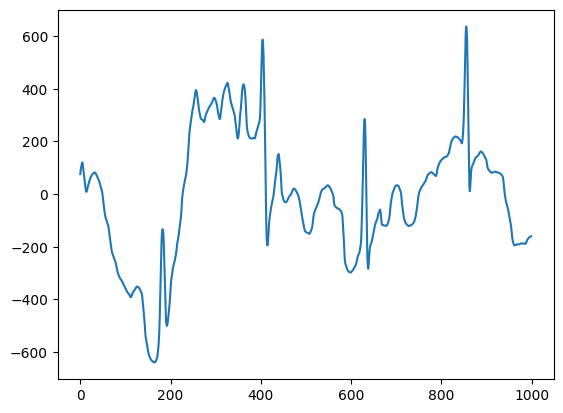

In [12]:
def plotwave(x, n=1000):
    plt.plot(x[:n])

plotwave(data_1lead[19][0])

In [13]:
value_counts = dataset_1lead.get_value_counts(count=3)
weights = [sum(value_counts)/x for x in value_counts]
# weights[labelmap['~']] = weights[labelmap['N']]

In [14]:
value_counts

[5076, 2415, 758]

# Training

## Single-Lead Model

Fold 1
Epoch:10/200 AVG Training Loss:2.56983 AVG Test Loss:2.57815 AVG Training F1 51.51 % AVG Test F1 51.00 %
Epoch:20/200 AVG Training Loss:2.39292 AVG Test Loss:2.40741 AVG Training F1 57.44 % AVG Test F1 59.64 %
Epoch:30/200 AVG Training Loss:2.30704 AVG Test Loss:2.40869 AVG Training F1 59.18 % AVG Test F1 62.92 %
Epoch:40/200 AVG Training Loss:2.30652 AVG Test Loss:2.26456 AVG Training F1 59.54 % AVG Test F1 64.23 %
Epoch:50/200 AVG Training Loss:2.27795 AVG Test Loss:2.34529 AVG Training F1 60.79 % AVG Test F1 65.50 %
Epoch:60/200 AVG Training Loss:2.22168 AVG Test Loss:2.17880 AVG Training F1 61.40 % AVG Test F1 65.48 %
Epoch:70/200 AVG Training Loss:2.25661 AVG Test Loss:2.17255 AVG Training F1 59.38 % AVG Test F1 61.62 %
Epoch:80/200 AVG Training Loss:2.24694 AVG Test Loss:2.18287 AVG Training F1 60.85 % AVG Test F1 64.79 %
Epoch:90/200 AVG Training Loss:2.18745 AVG Test Loss:2.12544 AVG Training F1 61.42 % AVG Test F1 64.00 %
Epoch:100/200 AVG Training Loss:2.18800 AVG Test

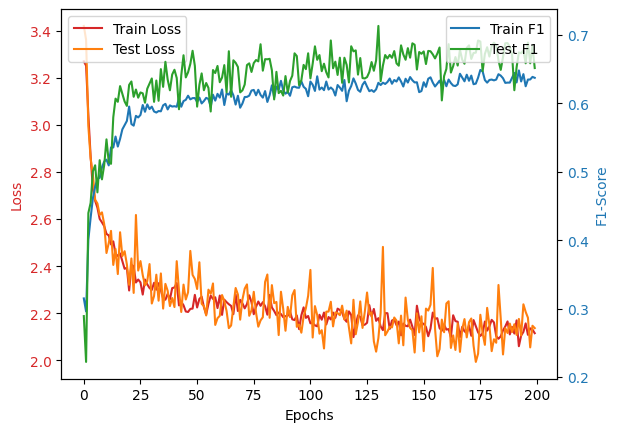

Overall results of 5 fold cross-validation
Train: Average loss 2.115098237991333, average F1 score 64.89903579346937
Test: Average loss 2.136601897386404, average F1 score 71.33482013668817


In [15]:
# Train k-fold crossvalidated model on 1 lead data

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.lr = 0.002
trainparams.n_epochs = 200

history, confusion_list = train_kfold_model(dataset_1lead, trainparams, test=True)

plot_tt_graph(history, idx=0)
display_results(history,trainparams=trainparams)

In [16]:
def plt_c(cm):
    labelmap2 = {x:y for y,x in labelmap.items()}

    # Converting the confusion matrix to fraction
    cm_fraction = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm_fraction)

    # Creating a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_fraction, annot=True, fmt=".2f", cmap='Blues', xticklabels=[labelmap2[i] for i in range(4)], yticklabels=[labelmap2[i] for i in range(4)])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix (as fraction)')
    plt.show()

In [19]:
## Build model on entire 1lead dataset and save to buffer

buffer = io.BytesIO()

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs = 200

model, history = train_entire_model(dataset_1lead, trainparams)

torch.save(model.state_dict(), buffer)

Epoch:10/200 AVG Training Loss:3.29669 AVG Test Loss:3.29650 AVG Training F1 29.42 % AVG Test F1 32.32 %
Epoch:20/200 AVG Training Loss:2.48592 AVG Test Loss:2.33453 AVG Training F1 54.24 % AVG Test F1 54.74 %
Epoch:30/200 AVG Training Loss:2.25480 AVG Test Loss:2.21158 AVG Training F1 60.29 % AVG Test F1 62.04 %
Epoch:40/200 AVG Training Loss:2.21156 AVG Test Loss:2.08800 AVG Training F1 60.96 % AVG Test F1 62.10 %
Epoch:50/200 AVG Training Loss:2.13030 AVG Test Loss:1.98989 AVG Training F1 62.20 % AVG Test F1 67.09 %
Epoch:60/200 AVG Training Loss:2.12174 AVG Test Loss:1.96612 AVG Training F1 63.69 % AVG Test F1 67.08 %
Epoch:70/200 AVG Training Loss:2.03657 AVG Test Loss:2.07021 AVG Training F1 64.25 % AVG Test F1 67.42 %
Epoch:80/200 AVG Training Loss:2.04985 AVG Test Loss:1.93150 AVG Training F1 64.65 % AVG Test F1 66.62 %
Epoch:90/200 AVG Training Loss:2.04467 AVG Test Loss:1.90549 AVG Training F1 64.65 % AVG Test F1 66.48 %
Epoch:100/200 AVG Training Loss:2.04734 AVG Test Loss:1

## Transfer

Fold 1
Epoch:10/100 AVG Training Loss:1.09874 AVG Test Loss:1.09820 AVG Training F1 28.83 % AVG Test F1 16.66 %
Epoch:20/100 AVG Training Loss:1.09371 AVG Test Loss:1.09491 AVG Training F1 39.32 % AVG Test F1 39.96 %
Epoch:30/100 AVG Training Loss:1.04438 AVG Test Loss:1.03827 AVG Training F1 49.15 % AVG Test F1 54.85 %
Epoch:40/100 AVG Training Loss:0.83162 AVG Test Loss:0.86525 AVG Training F1 62.99 % AVG Test F1 59.94 %
Epoch:50/100 AVG Training Loss:0.69691 AVG Test Loss:0.81745 AVG Training F1 70.11 % AVG Test F1 62.17 %
Epoch:60/100 AVG Training Loss:0.57408 AVG Test Loss:0.78042 AVG Training F1 75.29 % AVG Test F1 64.65 %
Epoch:70/100 AVG Training Loss:0.41450 AVG Test Loss:0.79846 AVG Training F1 84.11 % AVG Test F1 64.06 %
Epoch:80/100 AVG Training Loss:0.42168 AVG Test Loss:0.80893 AVG Training F1 82.72 % AVG Test F1 65.69 %
Early stopping triggered after epoch 81
Fold 2
Epoch:10/100 AVG Training Loss:1.09332 AVG Test Loss:1.09623 AVG Training F1 37.34 % AVG Test F1 34.53 %
E

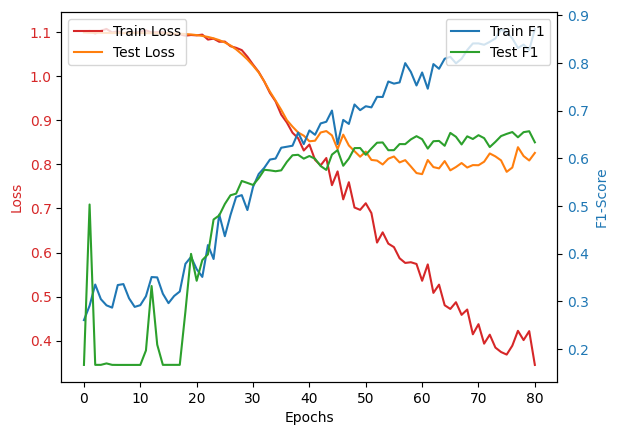

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.31075874517361324, average F1 score 89.79998418660458
Test: Average loss 0.8270880524069071, average F1 score 67.88330871172583


In [ ]:
## Control training - no transfer
## k-fold with leave-(k-1)-out

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, test=True)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:0.69024 AVG Test Loss:0.62090 AVG Training F1 71.00 % AVG Test F1 76.77 %
Epoch:20/100 AVG Training Loss:0.52422 AVG Test Loss:0.56012 AVG Training F1 78.24 % AVG Test F1 79.22 %
Epoch:30/100 AVG Training Loss:0.44836 AVG Test Loss:0.47627 AVG Training F1 81.84 % AVG Test F1 83.34 %
Epoch:40/100 AVG Training Loss:0.40774 AVG Test Loss:0.45701 AVG Training F1 82.46 % AVG Test F1 81.57 %
Epoch:50/100 AVG Training Loss:0.37477 AVG Test Loss:0.38592 AVG Training F1 85.56 % AVG Test F1 87.06 %
Epoch:60/100 AVG Training Loss:0.36028 AVG Test Loss:0.37817 AVG Training F1 85.07 % AVG Test F1 87.06 %
Epoch:70/100 AVG Training Loss:0.34229 AVG Test Loss:0.35782 AVG Training F1 86.60 % AVG Test F1 88.32 %
Epoch:80/100 AVG Training Loss:0.32718 AVG Test Loss:0.39800 AVG Training F1 86.89 % AVG Test F1 86.62 %
Early stopping triggered after epoch 90
Fold 2
Epoch:10/100 AVG Training Loss:0.74529 AVG Test Loss:0.76951 AVG Training F1 65.61 % AVG Test F1 65.75 %
E

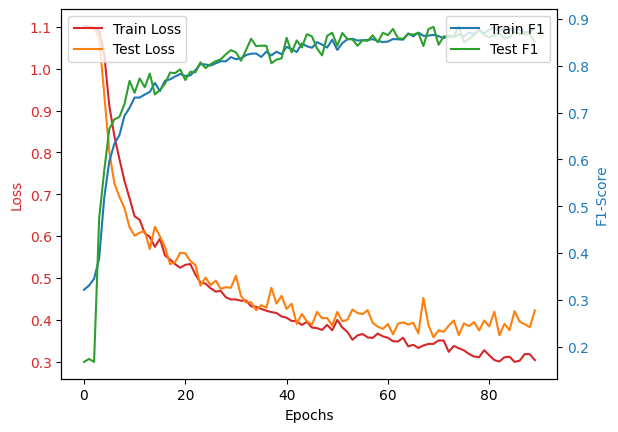

Overall results of 10 fold cross-validation with leave-1-out
Train: Average loss 0.3627599724878867, average F1 score 86.13945932811858
Test: Average loss 0.4687686224778494, average F1 score 83.40468130147691


In [ ]:
## Control training - no transfer
## k-fold with leave-1-out

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=1
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

In [20]:
## Train 10-fold crossvalidated model transferred, 1 -> 12 lead data
## No inter-channel connections, pure vote model

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=5

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferAdaptersCNNModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1


TypeError: TransferAdaptersCNNModel.get_l1_weightdiff() missing 1 required positional argument: 'map'

Fold 1
Epoch:10/100 AVG Training Loss:0.58426 AVG Test Loss:0.48590 AVG Training F1 80.91 % AVG Test F1 79.65 %
Epoch:20/100 AVG Training Loss:0.44925 AVG Test Loss:0.45725 AVG Training F1 88.62 % AVG Test F1 81.14 %
Early stopping triggered after epoch 21
Fold 2
Epoch:10/100 AVG Training Loss:0.56831 AVG Test Loss:0.49725 AVG Training F1 82.01 % AVG Test F1 81.21 %
Epoch:20/100 AVG Training Loss:0.45606 AVG Test Loss:0.46172 AVG Training F1 87.46 % AVG Test F1 81.44 %
Early stopping triggered after epoch 28
Fold 3
Epoch:10/100 AVG Training Loss:0.56505 AVG Test Loss:0.47208 AVG Training F1 81.09 % AVG Test F1 81.39 %
Early stopping triggered after epoch 19
Fold 4
Epoch:10/100 AVG Training Loss:0.58185 AVG Test Loss:0.49426 AVG Training F1 84.19 % AVG Test F1 80.37 %
Early stopping triggered after epoch 18
Fold 5
Epoch:10/100 AVG Training Loss:0.52057 AVG Test Loss:0.47343 AVG Training F1 83.71 % AVG Test F1 80.97 %
Epoch:20/100 AVG Training Loss:0.44608 AVG Test Loss:0.50170 AVG Train

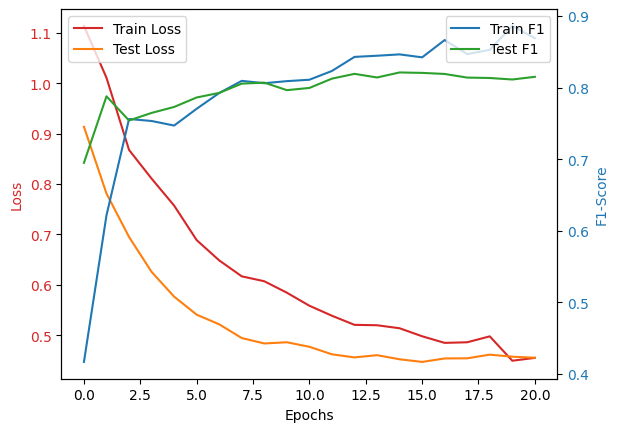

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.4446424474318823, average F1 score 88.8207796255827
Test: Average loss 0.45676317531615496, average F1 score 82.23261265745947


In [19]:
## Train 10-fold crossvalidated model transferred, 1 -> 12 lead data
## No inter-channel connections, pure vote model

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=5

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferFCModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:1.11792 AVG Test Loss:0.60508 AVG Training F1 76.52 % AVG Test F1 75.81 %
Epoch:20/100 AVG Training Loss:0.97736 AVG Test Loss:0.46342 AVG Training F1 82.70 % AVG Test F1 81.81 %
Epoch:30/100 AVG Training Loss:0.99292 AVG Test Loss:0.46052 AVG Training F1 86.76 % AVG Test F1 80.63 %
Epoch:40/100 AVG Training Loss:0.90767 AVG Test Loss:0.46928 AVG Training F1 89.86 % AVG Test F1 79.76 %
Epoch:50/100 AVG Training Loss:0.85665 AVG Test Loss:0.44399 AVG Training F1 93.34 % AVG Test F1 81.45 %
Early stopping triggered after epoch 55
Fold 2
Epoch:10/100 AVG Training Loss:1.18573 AVG Test Loss:0.59595 AVG Training F1 77.38 % AVG Test F1 76.83 %
Epoch:20/100 AVG Training Loss:0.97872 AVG Test Loss:0.47727 AVG Training F1 84.97 % AVG Test F1 80.80 %
Epoch:30/100 AVG Training Loss:0.93309 AVG Test Loss:0.47187 AVG Training F1 88.88 % AVG Test F1 79.95 %
Epoch:40/100 AVG Training Loss:0.90617 AVG Test Loss:0.45376 AVG Training F1 91.42 % AVG Test F1 81.16 %
E

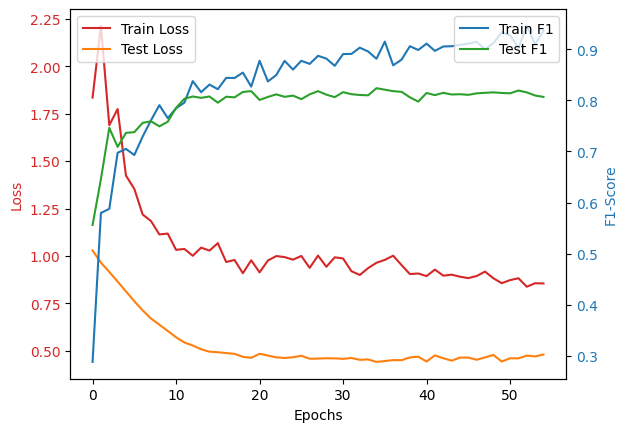

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.8862647374471029, average F1 score 94.56148504182588
Test: Average loss 0.46920593927303955, average F1 score 82.66015937907724


In [20]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data
## Transfer adds new fc layer as well as allowing intermediate connections between LSTM1 and LSTM2

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, TransferAdaptersLSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/200 AVG Training Loss:0.82041 AVG Test Loss:0.66103 AVG Training F1 70.91 % AVG Test F1 75.74 %
Epoch:20/200 AVG Training Loss:0.61770 AVG Test Loss:0.49388 AVG Training F1 81.26 % AVG Test F1 80.02 %
Epoch:30/200 AVG Training Loss:0.52319 AVG Test Loss:0.48436 AVG Training F1 87.27 % AVG Test F1 79.85 %
Epoch:40/200 AVG Training Loss:0.51787 AVG Test Loss:0.48826 AVG Training F1 86.32 % AVG Test F1 80.40 %
Early stopping triggered after epoch 45
Fold 2
Epoch:10/200 AVG Training Loss:0.85165 AVG Test Loss:0.73365 AVG Training F1 61.78 % AVG Test F1 61.67 %
Epoch:20/200 AVG Training Loss:0.69750 AVG Test Loss:0.56817 AVG Training F1 75.20 % AVG Test F1 79.31 %
Epoch:30/200 AVG Training Loss:0.59370 AVG Test Loss:0.53264 AVG Training F1 82.12 % AVG Test F1 78.19 %
Epoch:40/200 AVG Training Loss:0.59516 AVG Test Loss:0.51559 AVG Training F1 79.84 % AVG Test F1 79.76 %
Epoch:50/200 AVG Training Loss:0.57029 AVG Test Loss:0.50500 AVG Training F1 82.99 % AVG Test F1 80.36 %
E

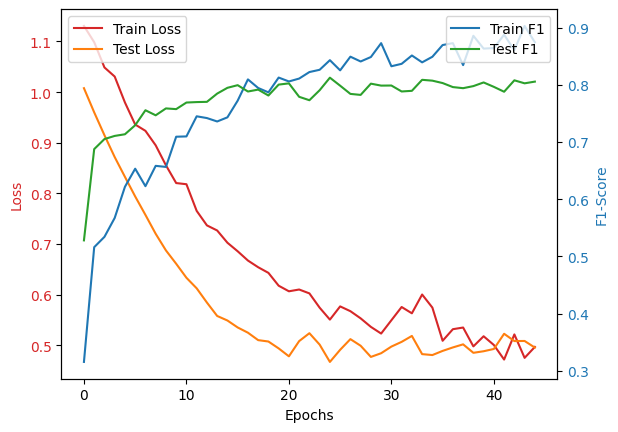

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.4738410204648972, average F1 score 91.5063753522111
Test: Average loss 0.5157583909730116, average F1 score 82.102040895765


In [21]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data
## Transfer adds new fc layer and new LSTM layer

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.n_epochs=200
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=20

history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

In [22]:
# ## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

# trainparams = TrainParams()
# trainparams.weights = weights
# trainparams.labelmap = labelmap
# trainparams.k=10
# trainparams.m=9
# trainparams.early_stopping=20


# for base_decay in [0.00001 * 2 ** i for i in range(10)]:
#     trainparams.base_decay = base_decay

#     history = train_kfold_transfer_model(dataset_12lead, trainparams, Transfer1LSTMModel, buffer=buffer, test=False, verbose=False)

#     # plot_tt_graph(history, idx=0)

#     print(f'\n\n\n##### decay rate {base_decay}')
#     display_results(history, trainparams=trainparams)

### Varying Dataset Size

In [23]:
models = [
    TransferFCModel,
    TransferAdaptersLSTMModel,
    Transfer1LSTMModel
]

km_list = [
    (10, 1),
    (10, 2),
    (10, 3),
    (10, 4),
    (10, 5),
    (10, 6),
    (10, 7),
    (10, 8),
    (7, 6),
    (10, 9),
    (15, 14),
    (20, 19),
    (30, 29),
    (40, 39),
    (50, 49)
]

test = False

hist = {}

for model in models:
    hist[model] = [{},{}]
    print(f'model {model.__name__}')

    for random_init in [True, False]:
        for k,m in km_list:
            trainparams = TrainParams()
            trainparams.weights = weights
            trainparams.labelmap = labelmap
            trainparams.n_epochs=200
            trainparams.k=k
            trainparams.m=m
            trainparams.early_stopping=5

            if random_init:
                history = train_kfold_transfer_model(dataset_12lead, trainparams, model, test=test, verbose=False)
            else:
                history = train_kfold_transfer_model(dataset_12lead, trainparams, model, buffer=buffer, test=test, verbose=False)

            hist[model][int(random_init)][(k,m)] = history

model TransferFCModel


KeyboardInterrupt: 

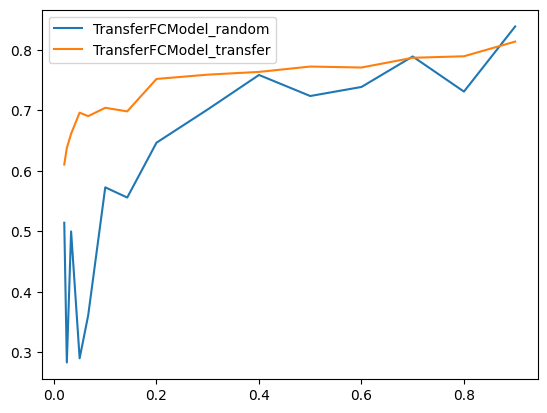

In [ ]:
def display_history_varying_trainsize(hist):
    legend = []

    for model in hist.keys():
        for random_init in [True, False]:
            values = []

            for k,m in hist[model][int(random_init)].keys():
                perc_train = (k-m)/k
                
                this_hist = hist[model][int(random_init)][(k,m)]
                # print([max(x) for x in this_hist['test_F']])
                values.append((perc_train, np.mean([max(x) for x in this_hist['test_F']])))

            x,y = zip(*values)
            plt.plot(list(x), list(y))

            # plt.plot(values)
                
            if random_init:
                legend.append(f'{model.__name__}_random')
            else:
                legend.append(f'{model.__name__}_transfer')

    plt.legend(legend)

    plt.show()


display_history_varying_trainsize(hist)

## Augmented Data

In [ ]:
control_dataset = WindowDataset(data_12lead, labelmap, device=device, trim_samples=1000)

3318it [00:03, 832.58it/s]


In [ ]:
def test_forwards(model_1,model_2,dataset,labelmap,device,batch_size=128,max_norm=1):
    # print(model_1)
    device = next(model_1.parameters()).device

    dataloader = DataLoader(dataset, batch_size=batch_size)

    model_1.eval()
    model_2.eval()
    for i,batch in enumerate(dataloader, 0):
        x, label = batch

        y = model_1.forward(x)

        y = model_2.forward(x)

        break

In [ ]:
model_c = TransferFCModel(base=buffer).to(device)
model_t = TransferAdaptersCNNModel(base=buffer).to(device)
model_t.fc_layer = model_c.fc_layer

test_forwards(model_c, model_t, control_dataset, labelmap, device)

tensor([-0.0658,  0.4387,  0.1655], device='cuda:0', grad_fn=<SliceBackward0>)
BREAKKKK
tensor([-0.0658,  0.4387,  0.1655], device='cuda:0', grad_fn=<SliceBackward0>)


In [ ]:
augment_dataset = AugmentDataset(data_12lead, labelmap, device=device, trim_samples=1000)

3318it [00:04, 828.72it/s]


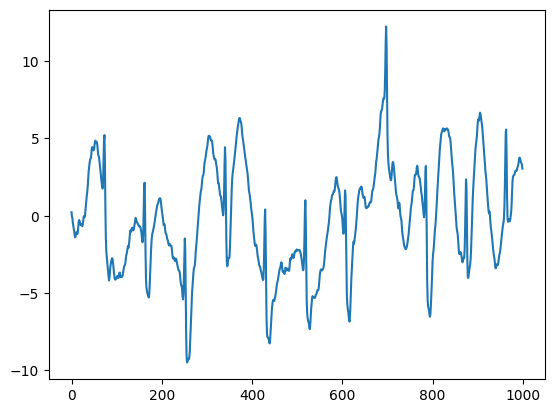

In [ ]:
waveform, label = augment_dataset.__getitem__(0)
plt.plot(waveform[:,4].cpu())

Fold 1
Epoch:10/100 AVG Training Loss:0.64414 AVG Test Loss:0.62156 AVG Training F1 74.76 % AVG Test F1 68.90 %
Epoch:20/100 AVG Training Loss:0.57146 AVG Test Loss:0.62669 AVG Training F1 80.04 % AVG Test F1 71.66 %
Early stopping triggered after epoch 26
Fold 2
Epoch:10/100 AVG Training Loss:0.63949 AVG Test Loss:0.63737 AVG Training F1 73.03 % AVG Test F1 66.54 %
Epoch:20/100 AVG Training Loss:0.56329 AVG Test Loss:0.63063 AVG Training F1 79.20 % AVG Test F1 68.47 %
Early stopping triggered after epoch 24
Fold 3
Epoch:10/100 AVG Training Loss:0.64488 AVG Test Loss:0.62954 AVG Training F1 70.97 % AVG Test F1 68.43 %
Epoch:20/100 AVG Training Loss:0.55922 AVG Test Loss:0.64474 AVG Training F1 80.83 % AVG Test F1 70.32 %
Early stopping triggered after epoch 21
Fold 4
Epoch:10/100 AVG Training Loss:0.61751 AVG Test Loss:0.60740 AVG Training F1 77.04 % AVG Test F1 69.00 %
Epoch:20/100 AVG Training Loss:0.57013 AVG Test Loss:0.60472 AVG Training F1 79.74 % AVG Test F1 70.97 %
Early stoppi

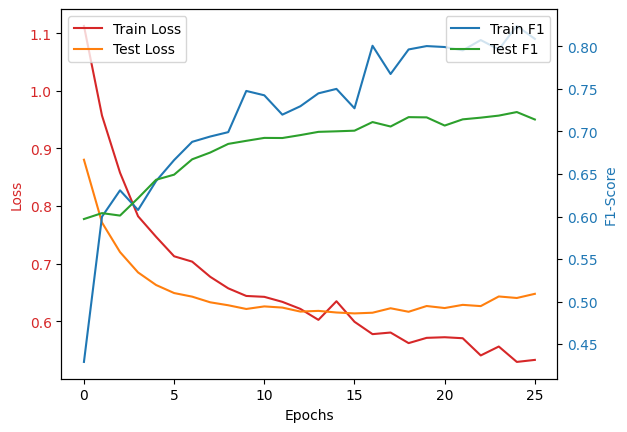

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.5469333022832871, average F1 score 82.37029112429666
Test: Average loss 0.6268632423132658, average F1 score 70.95195505315964


In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

# augment_dataset = AugmentDataset(data_12lead, labelmap, device=device, trim_samples=1000)

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=10

history = train_kfold_transfer_model(augment_dataset, trainparams, TransferFCModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:0.69351 AVG Test Loss:0.62845 AVG Training F1 67.61 % AVG Test F1 68.10 %
Epoch:20/100 AVG Training Loss:0.59682 AVG Test Loss:0.62819 AVG Training F1 78.68 % AVG Test F1 70.72 %
Epoch:30/100 AVG Training Loss:0.54100 AVG Test Loss:0.65190 AVG Training F1 82.42 % AVG Test F1 71.74 %
Early stopping triggered after epoch 31
Fold 2
Epoch:10/100 AVG Training Loss:0.65876 AVG Test Loss:0.61616 AVG Training F1 74.75 % AVG Test F1 69.04 %
Epoch:20/100 AVG Training Loss:0.56562 AVG Test Loss:0.62369 AVG Training F1 82.99 % AVG Test F1 71.52 %
Early stopping triggered after epoch 28
Fold 3
Epoch:10/100 AVG Training Loss:0.69786 AVG Test Loss:0.63371 AVG Training F1 71.00 % AVG Test F1 68.44 %
Epoch:20/100 AVG Training Loss:0.58068 AVG Test Loss:0.66242 AVG Training F1 79.16 % AVG Test F1 68.53 %
Early stopping triggered after epoch 25
Fold 4
Epoch:10/100 AVG Training Loss:0.69826 AVG Test Loss:0.61130 AVG Training F1 73.71 % AVG Test F1 69.83 %
Epoch:20/100

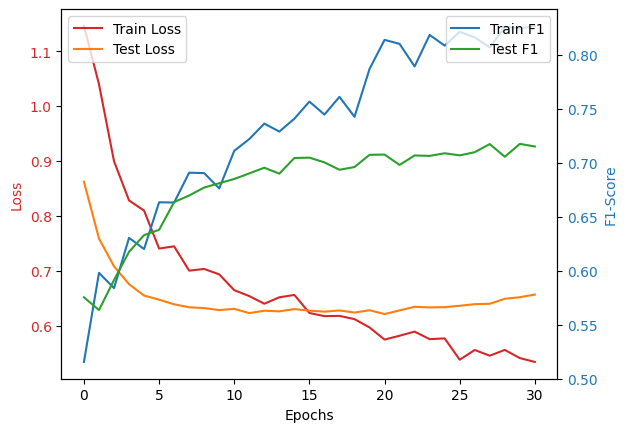

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 0.5670437584320703, average F1 score 83.6137106098672
Test: Average loss 0.6292031983534495, average F1 score 71.4467828603717


In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

# augment_dataset = AugmentDataset(data_12lead, labelmap, device=device, trim_samples=1000)

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=10

# control_dataset = WindowDataset(data_12lead[1000:1300], labelmap, device=device, trim_samples=1000)

history = train_kfold_transfer_model(augment_dataset, trainparams, TransferAdaptersCNNModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)

Fold 1
Epoch:10/100 AVG Training Loss:1.15965 AVG Test Loss:0.63911 AVG Training F1 67.22 % AVG Test F1 67.18 %
Epoch:20/100 AVG Training Loss:1.05177 AVG Test Loss:0.60643 AVG Training F1 78.17 % AVG Test F1 72.85 %
Epoch:30/100 AVG Training Loss:1.02290 AVG Test Loss:0.62792 AVG Training F1 82.70 % AVG Test F1 72.19 %
Early stopping triggered after epoch 33
Fold 2
Epoch:10/100 AVG Training Loss:1.14162 AVG Test Loss:0.65890 AVG Training F1 69.63 % AVG Test F1 66.18 %
Epoch:20/100 AVG Training Loss:1.01750 AVG Test Loss:0.63269 AVG Training F1 75.12 % AVG Test F1 67.35 %
Epoch:30/100 AVG Training Loss:0.99457 AVG Test Loss:0.62343 AVG Training F1 83.50 % AVG Test F1 69.63 %
Early stopping triggered after epoch 37
Fold 3
Epoch:10/100 AVG Training Loss:1.16220 AVG Test Loss:0.64571 AVG Training F1 66.42 % AVG Test F1 67.20 %
Epoch:20/100 AVG Training Loss:1.04108 AVG Test Loss:0.61289 AVG Training F1 75.78 % AVG Test F1 70.19 %
Epoch:30/100 AVG Training Loss:0.99962 AVG Test Loss:0.6165

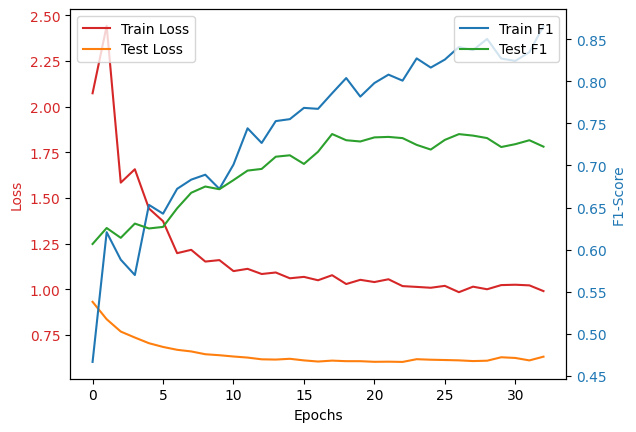

Overall results of 10 fold cross-validation with leave-9-out
Train: Average loss 1.0080268541971842, average F1 score 85.7565159428441
Test: Average loss 0.6204151092718044, average F1 score 73.67917537030897


In [ ]:
## Train k-fold crossvalidated model transferred, 1 -> 12 lead data

# augment_dataset = AugmentDataset(data_12lead, labelmap, device=device, trim_samples=1000)

trainparams = TrainParams()
trainparams.weights = weights
trainparams.labelmap = labelmap
trainparams.k=10
trainparams.m=9
trainparams.early_stopping=10

# control_dataset = WindowDataset(data_12lead[1000:1300], labelmap, device=device, trim_samples=1000)

history = train_kfold_transfer_model(augment_dataset, trainparams, TransferAdaptersLSTMModel, buffer=buffer, test=False)

plot_tt_graph(history, idx=0)
display_results(history, trainparams=trainparams)